In [31]:
import pandas as pd
# from tuner import computeMetric
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, f1_score
import config
from scipy import stats
import loader as load


def computeMetric(metric, cancer, p, all_pred_outputs, std=True, clamp_prediction_bounds=[]):
    current_outputs = all_pred_outputs[(all_pred_outputs.cancer == cancer) & (all_pred_outputs.p == p)]
    
    metric_means = []
    for iteration in current_outputs.iteration.unique():
        current_iteration_preds = current_outputs[current_outputs.iteration==iteration]

        if metric in ["precision", "recall", "f1-score"]:
            cur_report = classification_report(current_iteration_preds.actual, current_iteration_preds.predicted, output_dict=True, zero_division=0)
            cur_metric = cur_report["macro avg"][metric]
        elif metric == "rmse":
            raw_predictions = current_iteration_preds["predicted-raw"]
            if clamp_prediction_bounds:
                raw_predictions = np.clip(raw_predictions, clamp_prediction_bounds[0], clamp_prediction_bounds[1])
            cur_metric = mean_squared_error(current_iteration_preds.actual, raw_predictions, squared=False)
        elif metric == "f1-score(weighted)":
            cur_metric = f1_score(current_iteration_preds.actual, current_iteration_preds.predicted, zero_division=0)
        metric_means.append(cur_metric)

    metrics = np.array(metric_means)
    return metrics


In [44]:
cancer = "STAD"
results = ""

for target in ["tumor", "stage"][1:]:
    # target = "tumor"
    prediction_models = {
        "tumor": "SVC",
        # "stage": "rfreg"
        "stage": "enet"
    }
    selection_per_target = {
            "tumor": ["anova"],
            "stage": ["elasticnet", "pearson", "rfreg"][:2]
            # "stage": ["rfreg"]
        }
    model = prediction_models[target]
    # model = "enet"
    modalities = ["aak_ge", "tcma_gen"]
    # modalities = ["aak_ge", "tcma_gen_aak_ge"]
    integration = "ae"
    for selection in selection_per_target[target]:
        # for modalities in [("tcma_gen_aak_ge_ae", "tcma_gen_aak_ge"), ("tcma_gen_aak_ge_ae", "tcma_gen_ae"), ("tcma_gen_aak_ge_ae", "aak_ge_ae")]:
        for modalities in [(f"tcma_gen_aak_ge_{integration}", "tcma_gen_aak_ge"), (f"tcma_gen_aak_ge_{integration}", f"tcma_gen_{integration}"), (f"tcma_gen_aak_ge_{integration}", f"aak_ge_{integration}")][:1]:
            # prediction_tables_root = f"Data/Descriptor/Prediction_Tables/random_sampling/{target}/{model}"
            prediction_tables_root = f"Data/Descriptor/Prediction_Tables/super/random_sampling/{target}/{model}"
            l, r = [pd.read_csv(f"{prediction_tables_root}/{selection}/{x}_{selection}_predoutput.csv", index_col=None) for x in modalities]
            d = [l, r]
            pairs = [None, None]
            ps = (0, 100)
            for i, x in enumerate(d):
                if target=="stage":
                    metrics = computeMetric("rmse", cancer=cancer, p=ps[i], all_pred_outputs=x, clamp_prediction_bounds=config.prediction_bounds[target])
                else:
                    metrics = computeMetric("f1-score(weighted)", cancer=cancer, p=ps[i], all_pred_outputs=x, clamp_prediction_bounds=config.prediction_bounds[target])
                pairs[i] = metrics
            # np.mean(pairs[1])
            test = stats.mannwhitneyu(pairs[0], pairs[1])
            is_normal = (stats.normaltest(pairs[0]), stats.normaltest(pairs[1]))
            cur_result = f"{cancer}|{target}|{model}|{selection} for {modalities[0]} vs {modalities[1]}: {test}\n"
            results += cur_result
            print(cur_result) # | norm: {is_normal}") 
# load.saveDescriptor(results, r'Data\Descriptor\Description\stat_test\base.txt')
# load.saveDescriptor(results, r'Data\Descriptor\Description\stat_test\super_ae.txt')
load.saveDescriptor(results, rf'Data\Descriptor\Description\stat_test\super_{integration}_{p}_{model}.txt')
# r

STAD|stage|enet|elasticnet for tcma_gen_aak_ge_ae vs tcma_gen_aak_ge: MannwhitneyuResult(statistic=11541.0, pvalue=2.552122253432249e-13)

STAD|stage|enet|pearson for tcma_gen_aak_ge_ae vs tcma_gen_aak_ge: MannwhitneyuResult(statistic=22712.0, pvalue=0.019011872822146773)



(array([ 5., 15., 55., 52., 36., 16., 11.,  5.,  4.,  1.]),
 array([1.01984379, 1.0518113 , 1.08377881, 1.11574632, 1.14771384,
        1.17968135, 1.21164886, 1.24361637, 1.27558389, 1.3075514 ,
        1.33951891]),
 <BarContainer object of 10 artists>)

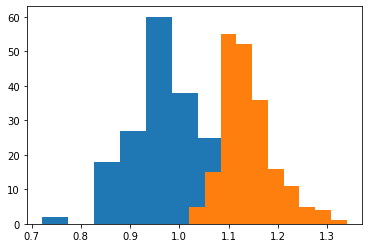

In [ ]:
import matplotlib.pyplot as plt
plt.hist(pairs[0])
plt.hist(pairs[1])

In [ ]:
from scipy import stats
# https://pythonfordatascienceorg.wordpress.com/wilcoxon-sign-ranked-test-python/
print(stats.wilcoxon(pairs[0], pairs[1]))
print(stats.mannwhitneyu(pairs[0], pairs[1]))

WilcoxonResult(statistic=621.0, pvalue=1.2451149461732018e-30)
MannwhitneyuResult(statistic=3743.0, pvalue=6.59693896379775e-45)


In [ ]:
# Compute all baselines